In [1]:
import math as m
import torch
import torchvision.transforms as T
from io import BytesIO
from PIL import Image
import requests
from scipy import stats

### Loading a test image

In [2]:
url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"
img = Image.open(BytesIO(requests.get(url).content)).convert("RGB")
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])
img_tensor = transform(img)
# img_tensor = img_tensor * 2 - 1

### Definition of diffusion steps

In [3]:
def naive_diffusion_step(x_t: torch.Tensor) -> torch.Tensor:
    shape = x_t.shape
    noise = torch.randn(shape)
    return x_t + noise

def diffusion_step(x_t: torch.Tensor, beta: float = 0.1) -> torch.Tensor:
    alpha = 1 - beta
    shape = x_t.shape
    noise = torch.randn(shape)
    return x_t * m.sqrt(alpha) + noise * m.sqrt(1 - alpha)

def full_diffusion_process(x_t: torch.Tensor, t_steps: int = 1000, diffusion_step_fn: callable = diffusion_step) -> torch.Tensor:
    frames = []
    means = []
    stds = []
    ks_results = []

    current_tensor = x_t.clone()
    for t in range(t_steps):
        frames.append(current_tensor.clone())
        means.append(current_tensor.mean().item())
        stds.append(current_tensor.std().item())

        flat = current_tensor.flatten()
        sample = flat[torch.randperm(flat.shape[0])[:1000]]
        ks_results.append(stats.kstest(sample.numpy(), 'norm'))

        current_tensor = diffusion_step_fn(current_tensor)
    
    return frames, means, stds, ks_results

In [4]:
import math
import matplotlib.pyplot as plt

def _plot_panel(ax, data, t, mean, std, pvalue, mode='image', plot_statistics=True):
    is_normal = pvalue > 0.05
    title = f"x_{t}.\n"
    if plot_statistics:
        title += f"Mean: {mean:.2f}, Std: {std:.2f}, \n"
    title += f"Distribution {'un' if not is_normal else ''}likely N(0, 1)"
    ax.set_title(title)

    if mode == 'image':
        ax.imshow(data.permute(1, 2, 0).numpy())
        ax.axis('off')
    elif mode == 'hist':
        ax.hist(data.flatten().numpy(), bins=50, density=True, color='skyblue', edgecolor='black')

def _plot_grid(frames, means, stds, ks_results, selected_ts, mode='image', plot_statistics=True):
    n = len(selected_ts)
    cols = m.ceil(m.sqrt(n))
    rows = n // cols + (n % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten() if n > 1 else [axes]

    for i, t in enumerate(selected_ts):
        _plot_panel(
            ax=axes[i], data=frames[t], t=t, mean=means[t],std=stds[t], pvalue=ks_results[t].pvalue, mode=mode, plot_statistics=plot_statistics
        )

    # Hide any unused axes
    for j in range(len(selected_ts), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    return fig, axes

def subplot(frames, means, stds, ks_results, selected_ts, plot_statistics=True):
    return _plot_grid(frames, means, stds, ks_results, selected_ts, mode='image', plot_statistics=plot_statistics)

def subplot_hist(frames, means, stds, ks_results, selected_ts, plot_statistics=True):
    return _plot_grid(frames, means, stds, ks_results, selected_ts, mode='hist', plot_statistics=plot_statistics)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.5010757..6.586968].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.773798..10.453359].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-102.706726..100.533646].


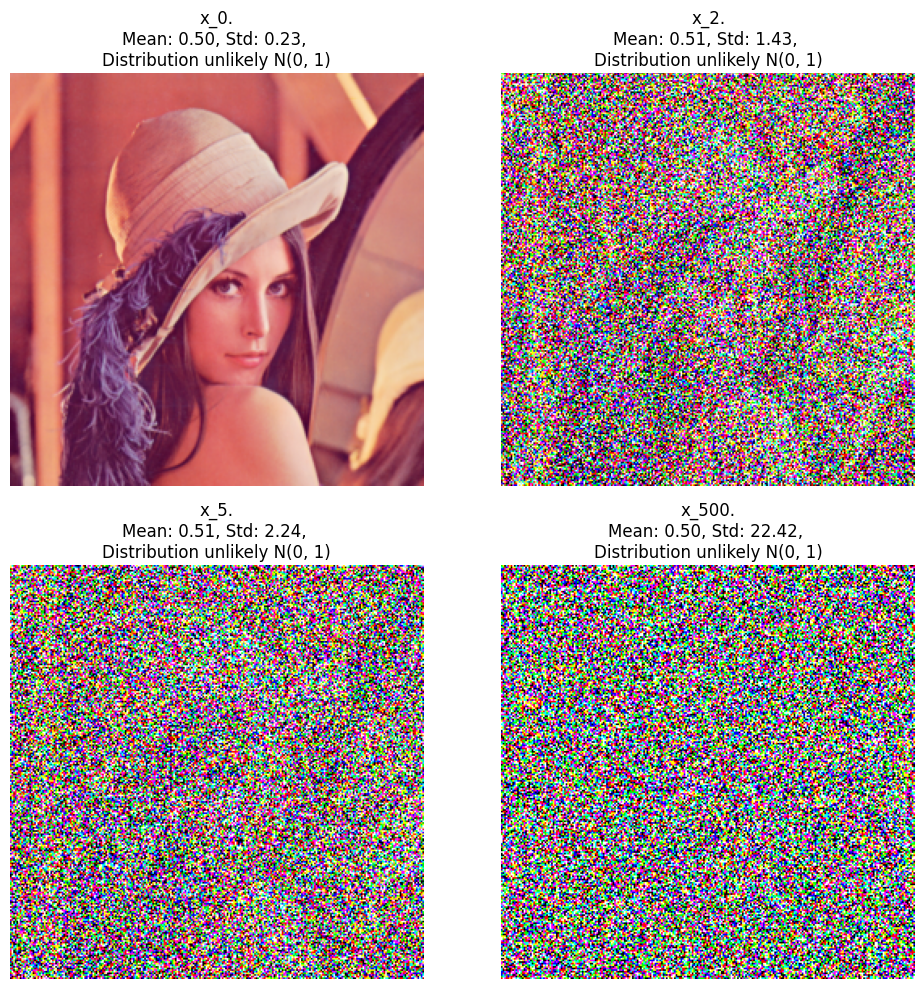

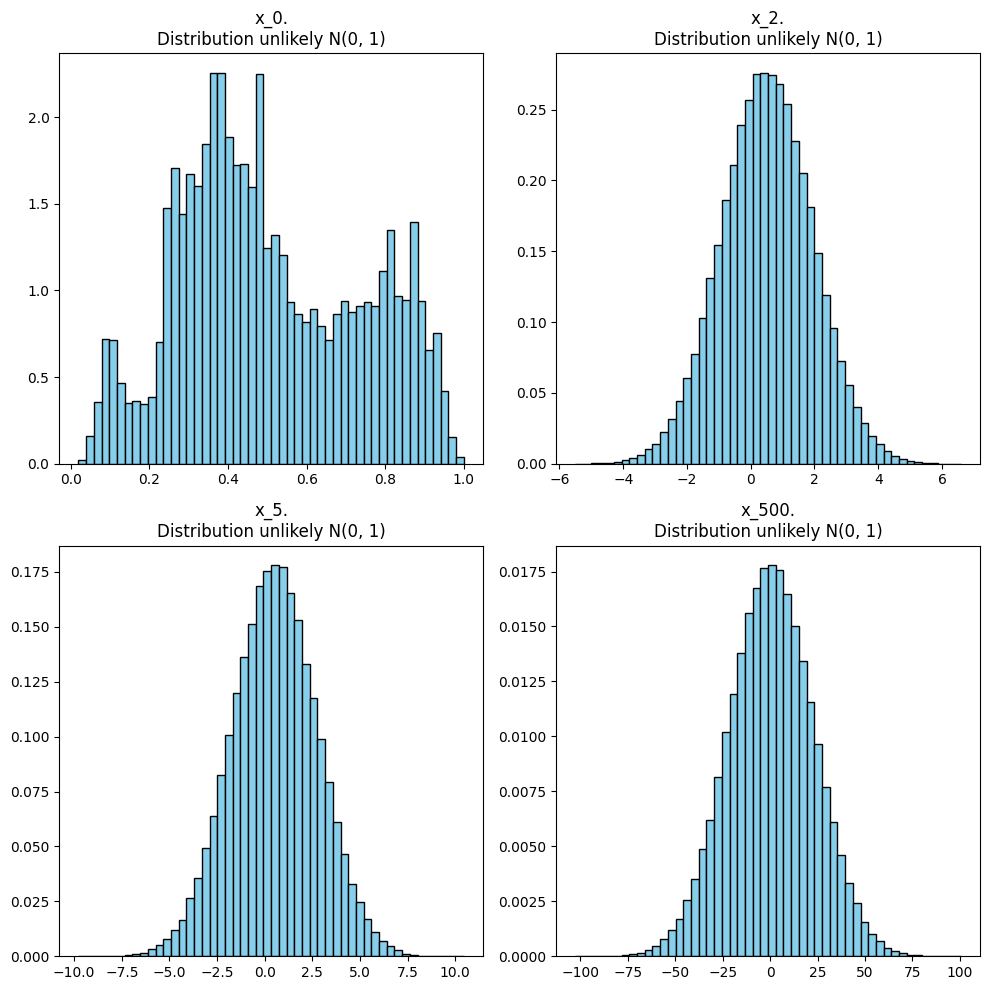

In [5]:
frames, means, stds, ks_results = full_diffusion_process(img_tensor, t_steps=501, diffusion_step_fn=naive_diffusion_step)
selected_ts = [0, 2, 5, 500]

fig, axes = subplot(frames, means, stds, ks_results, selected_ts, plot_statistics=True)
fig_hist, axes = subplot_hist(frames, means, stds, ks_results, selected_ts, plot_statistics=False)

fig.savefig("imgs/naive_diffusion_subplots.png", dpi=300, bbox_inches="tight")
fig_hist.savefig("imgs/naive_distribution_subplots.png", dpi=300, bbox_inches="tight")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8379884..2.645816].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.682115..3.5450697].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.322511..4.9152822].


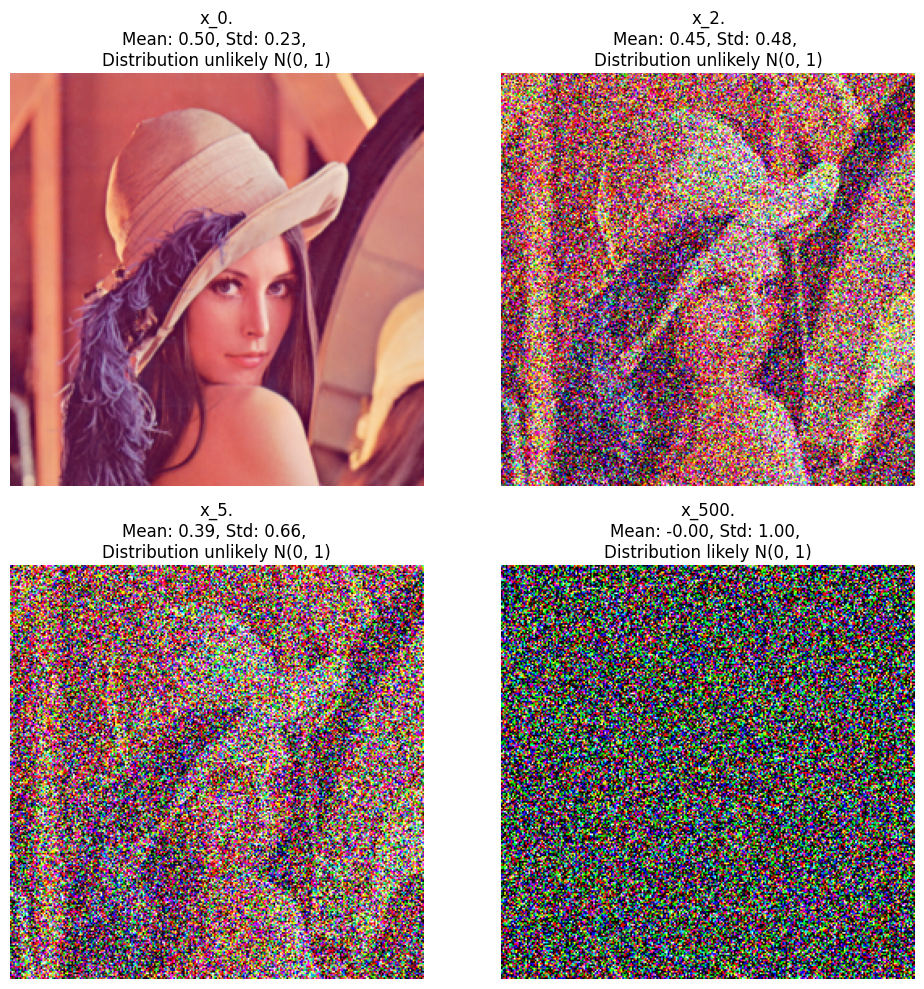

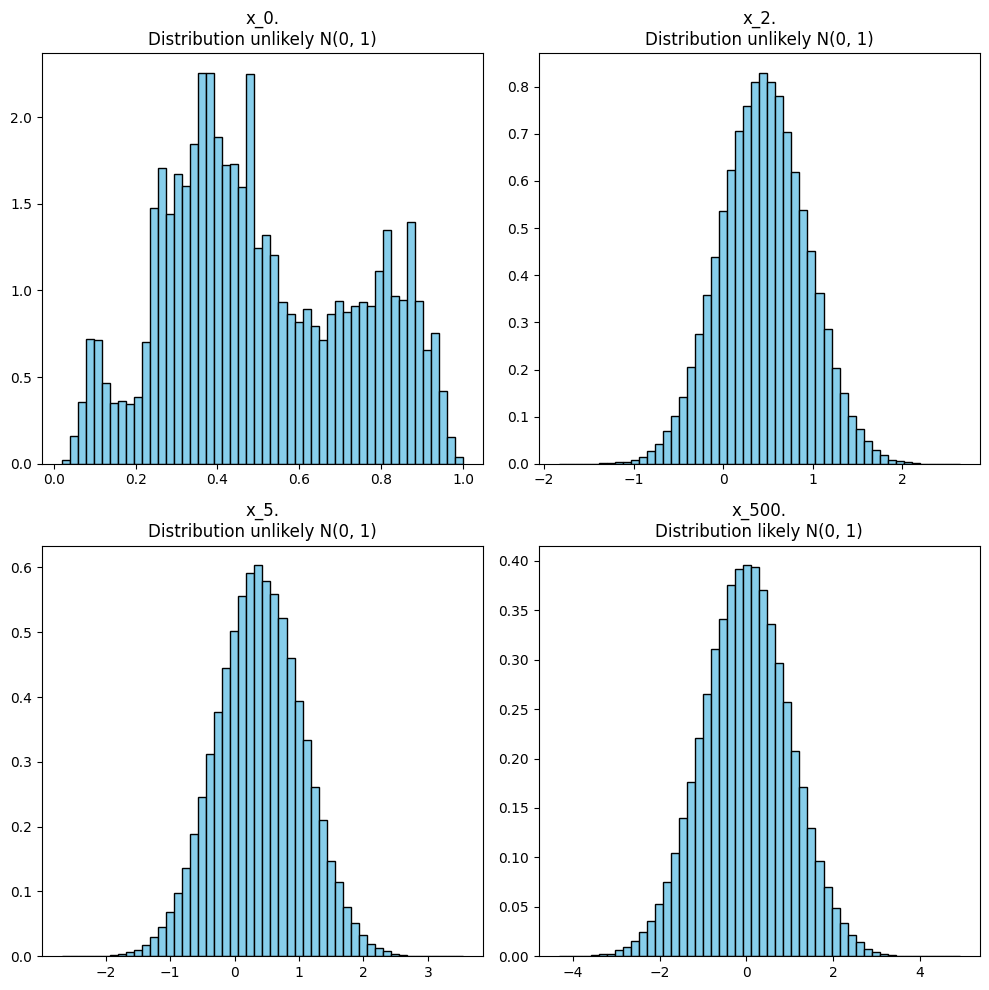

In [8]:
frames, means, stds, ks_results = full_diffusion_process(img_tensor, t_steps=501)
selected_ts = [0, 2, 5, 500]

fig, axes = subplot(frames, means, stds, ks_results, selected_ts, plot_statistics=True)
fig_hist, axes = subplot_hist(frames, means, stds, ks_results, selected_ts, plot_statistics=False)

fig.savefig("imgs/diffusion_subplots.png", dpi=300, bbox_inches="tight")
fig_hist.savefig("imgs/distribution_subplots.png", dpi=300, bbox_inches="tight")